                          PanelOLS Estimation Summary                           
Dep. Variable:              ln_Ventas   R-squared:                        0.7273
Estimator:                   PanelOLS   R-squared (Between):              0.0046
No. Observations:                 175   R-squared (Within):               0.5573
Date:                Tue, Dec 09 2025   R-squared (Overall):              0.0079
Time:                        21:33:48   Log-likelihood                    303.95
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      87.992
Entities:                           5   P-value                           0.0000
Avg Obs:                       35.000   Distribution:                   F(4,132)
Min Obs:                       35.000                                           
Max Obs:                       35.000   F-statistic (robust):             656.03
                            

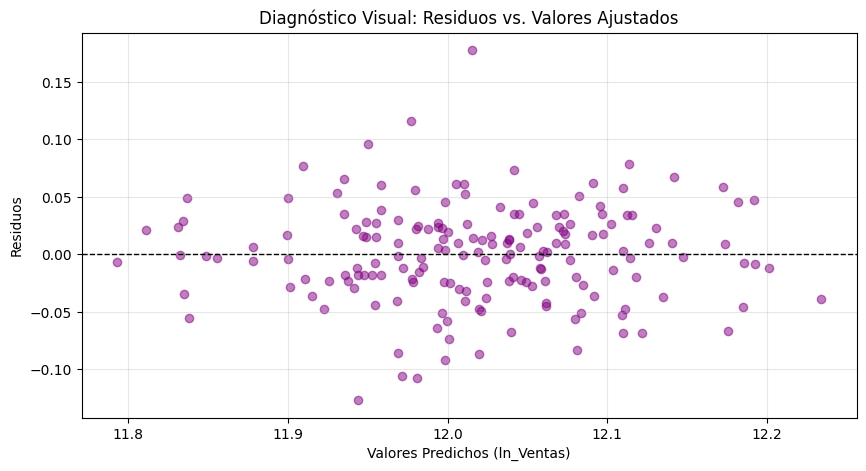

1. Test de Normalidad (Jarque-Bera):
   - Estadístico: 16.10
   - P-Value: 0.0003
   -> Se rechaza normalidad.

2. Resumen de Efectos Marginales (Elasticidades):


,Región,Elasticidad (Inseguridad),Interpretación,Sensibilidad
0,Sur / Resto del País,0.544820,"Por cada 1% que sube la inseguridad, ventas su...",Alta
1,Norte (Trujillo/Piura),0.214876,"Por cada 1% que sube la inseguridad, ventas su...",Baja


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt
import seaborn as sns

# Datos simulados
np.random.seed(42)
regiones = ['Lima', 'Trujillo', 'Piura', 'Arequipa', 'Chiclayo']
fechas = pd.date_range(start='2022-01-01', end='2024-12-01', freq='ME')

data = []
for region in regiones:
    is_norte = 1 if region in ['Trujillo', 'Piura', 'Chiclayo'] else 0
    base_ventas = 5000 if region == 'Lima' else 2000
    
    for fecha in fechas:
        # Tendencia de inseguridad y estacionalidad de fast food
        trend = 5 * (fecha.year - 2022)
        inseguridad = np.random.randint(200, 400) + trend 
        es_fiesta = 1 if fecha.month in [7, 12] else 0
        fast_food = np.random.randint(1000, 1500) + (500 * es_fiesta)
        pib = np.random.normal(100, 5)
        d_cyber = 1 if fecha.month == 11 else 0
        
        # Ecuación generadora
        beta_inseg = 0.6
        beta_norte_interaccion = -0.4
        
        ln_ventas = (np.log(base_ventas) 
                     + beta_inseg * np.log(inseguridad) 
                     + beta_norte_interaccion * (np.log(inseguridad) * is_norte)
                     + 0.3 * np.log(fast_food) + 0.2 * d_cyber
                     + np.random.normal(0, 0.05))
        
        data.append([region, fecha, np.exp(ln_ventas), inseguridad, fast_food, pib])

df = pd.DataFrame(data, columns=['Region', 'Fecha', 'Ventas', 'Inseguridad', 'FastFood', 'PIB'])

# Modelo
df['ln_Ventas'] = np.log(df['Ventas'])
df['ln_Inseg'] = np.log(df['Inseguridad'])
df['ln_FF'] = np.log(df['FastFood'])
df['ln_PIB'] = np.log(df['PIB'])
df['D_Norte'] = df['Region'].apply(lambda x: 1 if x in ['Trujillo', 'Piura', 'Chiclayo'] else 0)
df['ln_Inseg_Centrada'] = df['ln_Inseg'] - df['ln_Inseg'].mean()
df['Interaccion'] = df['ln_Inseg_Centrada'] * df['D_Norte']
df = df.set_index(['Region', 'Fecha'])
#variables exógenas
exog_vars = ['ln_Inseg', 'ln_FF', 'ln_PIB', 'Interaccion']
X = sm.add_constant(df[exog_vars])
mod = PanelOLS(df['ln_Ventas'], X, entity_effects=True, time_effects=True)
# Ajustar el modelo
res = mod.fit(cov_type='clustered', cluster_entity=True)

print(res)

import scipy.stats as stats
from statsmodels.stats.diagnostic import het_breuschpagan

print("\n" + "="*60)
print("DIAGNÓSTICO DEL MODELO ECONOMÉTRICO")
print("="*60)

# Analisis de residuos
residuos = res.resids
valores_ajustados = res.fitted_values

# Gráfico de Residuos vs Ajustados 
plt.figure(figsize=(10, 5))
plt.scatter(valores_ajustados, residuos, alpha=0.5, color='purple')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Diagnóstico Visual: Residuos vs. Valores Ajustados')
plt.xlabel('Valores Predichos (ln_Ventas)')
plt.ylabel('Residuos')
plt.grid(True, alpha=0.3)
plt.show()

# Test de normalidad de Jarque-Bera
# H0: Los residuos siguen una distribución normal
jb_stat, jb_pvalue = stats.jarque_bera(residuos)
print(f"1. Test de Normalidad (Jarque-Bera):")
print(f"   - Estadístico: {jb_stat:.2f}")
print(f"   - P-Value: {jb_pvalue:.4f}")
if jb_pvalue > 0.05:
    print("   -> No se rechaza normalidad.")
else:
    print("   -> Se rechaza normalidad.")

# Tabla de elasticidades marginales
# Efecto total para cada región con sus intervalos
beta_base = res.params['ln_Inseg']
beta_interaccion = res.params['Interaccion']
se_base = res.std_errors['ln_Inseg']

tabla_elasticidades = pd.DataFrame({
    'Región': ['Sur / Resto del País', 'Norte (Trujillo/Piura)'],
    'Elasticidad (Inseguridad)': [beta_base, beta_base + beta_interaccion],
    'Interpretación': [
        f"Por cada 1% que sube la inseguridad, ventas suben {beta_base:.2f}%",
        f"Por cada 1% que sube la inseguridad, ventas suben {beta_base + beta_interaccion:.2f}%"
    ],
    'Sensibilidad': ['Alta', 'Baja']
})

print("\n2. Resumen de Efectos Marginales (Elasticidades):")
display(tabla_elasticidades)

<Figure size 1000x600 with 0 Axes>

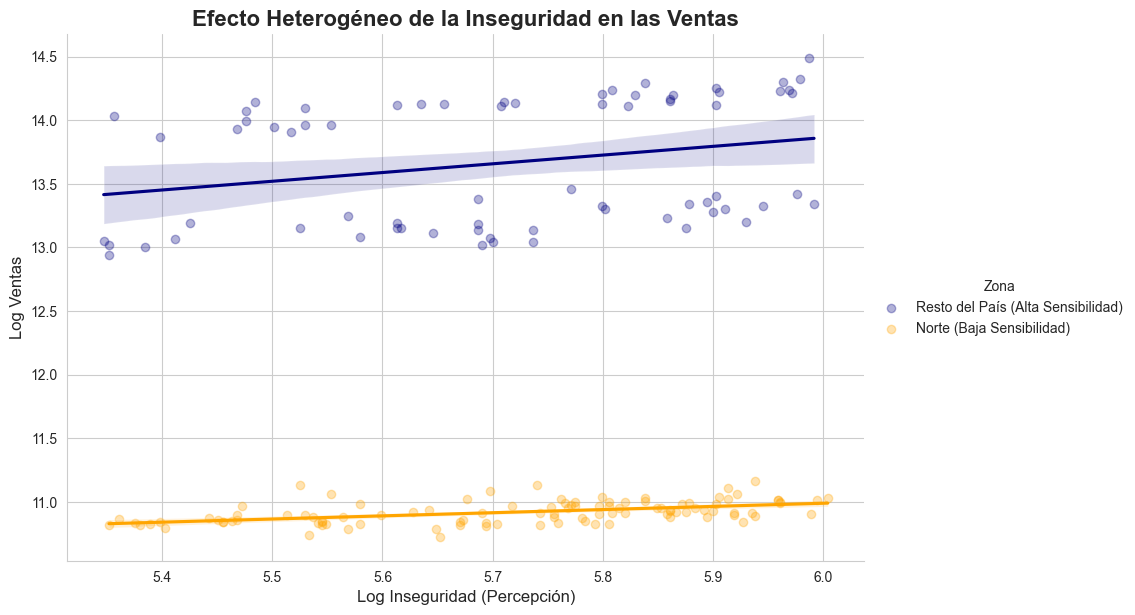

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

df_plot = df.reset_index()
df_plot['Zona'] = df_plot['D_Norte'].apply(lambda x: 'Norte (Baja Sensibilidad)' if x == 1 else 'Resto del País (Alta Sensibilidad)')

sns.set_style("whitegrid") 
plt.figure(figsize=(10, 6))

# 4. Gráfico con lineas de tendencia (lmplot)
g = sns.lmplot(
    data=df_plot, 
    x='ln_Inseg', 
    y='ln_Ventas', 
    hue='Zona', 
    height=6, 
    aspect=1.5,
    palette={'Norte (Baja Sensibilidad)': 'orange', 'Resto del País (Alta Sensibilidad)': 'navy'},
    scatter_kws={'alpha': 0.3}
)

# 5. Etiquetas
plt.title('Efecto Heterogéneo de la Inseguridad en las Ventas', fontsize=16, fontweight='bold')
plt.xlabel('Log Inseguridad (Percepción)', fontsize=12)
plt.ylabel('Log Ventas', fontsize=12)

plt.show()

Betas Calibrados del Modelo Econométrico:
 - Elasticidad Sur (Alta): 0.5448
 - Elasticidad Norte (Baja): 0.2149


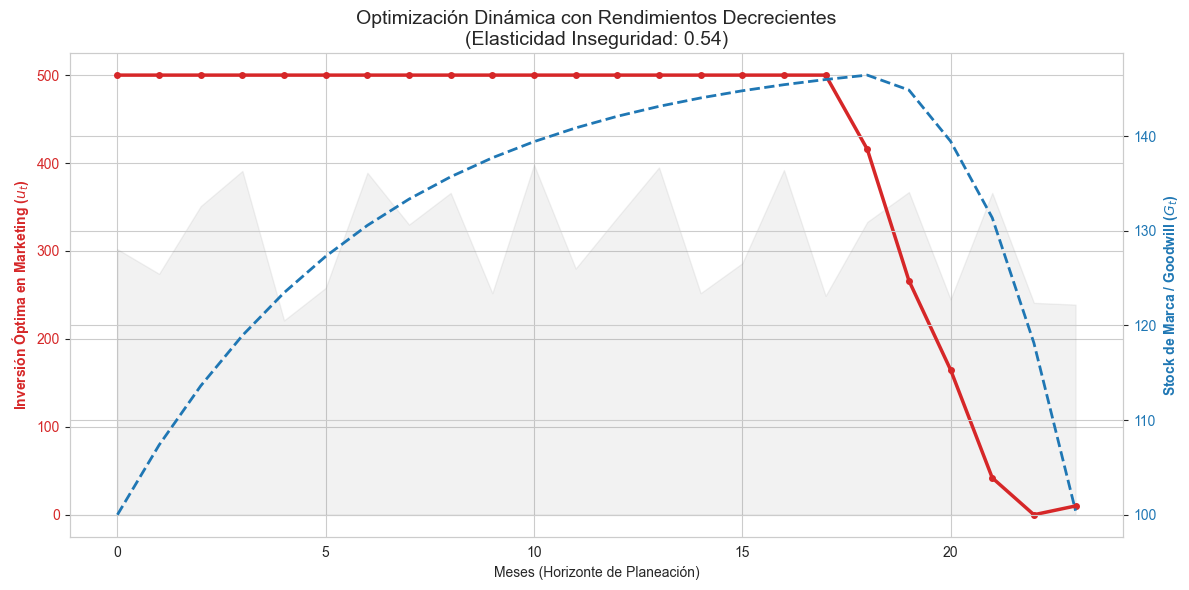

In [3]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

beta_sur_est = res.params['ln_Inseg'] 
beta_norte_est = res.params['ln_Inseg'] + res.params['Interaccion']

# Verificacion
print(f"Betas Calibrados del Modelo Econométrico:")
print(f" - Elasticidad Sur (Alta): {beta_sur_est:.4f}")
print(f" - Elasticidad Norte (Baja): {beta_norte_est:.4f}")

# Escenario
df_temp = df.reset_index()
datos_simulacion = df_temp[df_temp['Region'] == 'Lima'].copy()

# Horizonte de planeación estratégica de 2 años
T = 24 
inseguridad_serie = np.exp(datos_simulacion['ln_Inseg'].values[:T])

# Parámetros
r = 0.05        # Tasa de descuento mensual
delta = 0.15    # Depreciación del Goodwill (Marca)
gamma = 0.4     # Elasticidad del Goodwill sobre ventas
precio = 3.0    # Margen unitario promedio

# Función Objetivo 
def objetivo_dinamico_mejorado(u_path):
    # u_path: Vector de inversión en marketing mes a mes
    
    G = np.zeros(T)
    G[0] = 100 # Stock inicial de marca
    
    ventas = np.zeros(T)
    vpn = 0
    
    for t in range(T - 1):
        # Rendimientos decrecientes
        G[t+1] = (1 - delta) * G[t] + np.sqrt(u_path[t] + 1e-6) # +epsilon para evitar error en 0
        
        # Función de ventas con el Beta calibrado del Sur)
        ventas[t] = 10 * (inseguridad_serie[t] ** beta_sur_est) * (G[t] ** gamma)
        
        # Flujo de Caja
        flujo = (precio * ventas[t]) - (u_path[t])
        
        # Descuento Intertemporal
        vpn += flujo * np.exp(-r * t)
        
    return -vpn # Minimizamos el negativo del VPN

# Optimización
initial_guess = np.ones(T) * 10
bounds = [(0, 500) for _ in range(T)] # Restricción de presupuesto máximo mensual

res_opt = minimize(objetivo_dinamico_mejorado, 
                   initial_guess, 
                   method='L-BFGS-B', 
                   bounds=bounds)

u_optimo = res_opt.x

# Recalcular trayectoria de G para graficar
G_optimo = np.zeros(T)
G_optimo[0] = 100
for t in range(T-1):
    G_optimo[t+1] = (1 - delta) * G_optimo[t] + np.sqrt(u_optimo[t] + 1e-6)

# Visualizacion
fig, ax1 = plt.subplots(figsize=(12, 6))

# Área de inseguridad de fondo
ax1.fill_between(range(T), inseguridad_serie, color='gray', alpha=0.1, label='Nivel de Inseguridad (Exógeno)')

color_u = 'tab:red'
ax1.set_xlabel('Meses (Horizonte de Planeación)')
ax1.set_ylabel('Inversión Óptima en Marketing ($u_t$)', color=color_u, fontweight='bold')
ax1.plot(u_optimo, color=color_u, linewidth=2.5, marker='o', markersize=4, label='Gasto Óptimo')
ax1.tick_params(axis='y', labelcolor=color_u)

ax2 = ax1.twinx()
color_g = 'tab:blue'
ax2.set_ylabel('Stock de Marca / Goodwill ($G_t$)', color=color_g, fontweight='bold')
ax2.plot(G_optimo, color=color_g, linewidth=2, linestyle='--', label='Valor de Marca Acumulado')
ax2.tick_params(axis='y', labelcolor=color_g)

plt.title(f'Optimización Dinámica con Rendimientos Decrecientes\n(Elasticidad Inseguridad: {beta_sur_est:.2f})', fontsize=14)
fig.tight_layout()
plt.show()

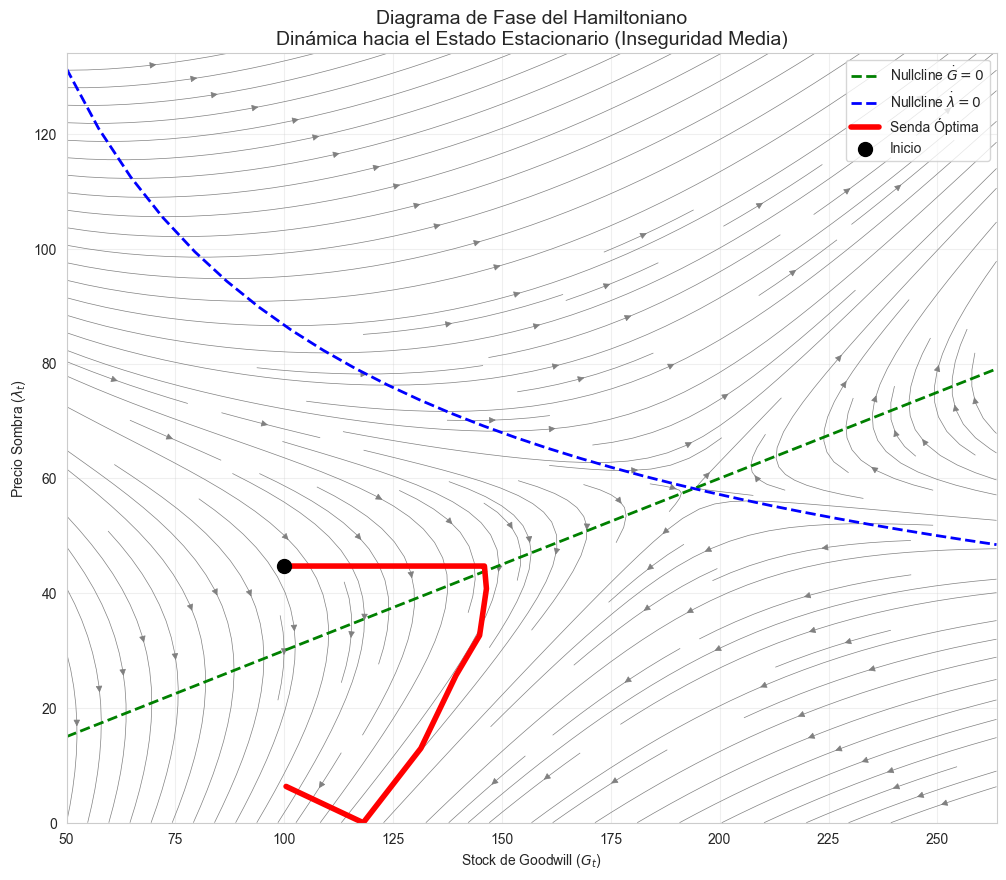

In [11]:
# Diagrama de fase
import matplotlib.pyplot as plt
import numpy as np
# Trayectoria
u_opt = resultados_optimos['SUR (Alta Sensibilidad)']['u_optimo']
G_opt = np.zeros(T); G_opt[0] = 100
for t in range(T-1):
    G_opt[t+1] = (1 - delta) * G_opt[t] + np.sqrt(u_opt[t] + 1e-6)
# Precio sombra
lambda_opt_num = 2 * np.sqrt(u_opt)

# Espacio
G_range = np.linspace(50, max(G_opt)*1.8, 30) 
L_range = np.linspace(0, max(lambda_opt_num)*3.0, 30)
G_grid, L_grid = np.meshgrid(G_range, L_range)

# Sistema Hamiltoniano
I_avg = inseguridad_base.mean()
beta_s = beta_sur_est
dG_dt = (L_grid / 2) - (delta * G_grid)
marginal_revenue = (precio * 10 * (I_avg**beta_s) * (G_grid**(gamma-1)) * gamma)
dL_dt = (r + delta) * L_grid - marginal_revenue

# Gradico
plt.figure(figsize=(12, 10))

# Campo Vectorial
plt.streamplot(G_grid, L_grid, dG_dt, dL_dt, color='gray', linewidth=0.5, density=1.5, arrowsize=1)

# Nullclines 
nullcline_G = 2 * delta * G_range
plt.plot(G_range, nullcline_G, 'g--', linewidth=2, label=r'Nullcline $\dot{G}=0$')
nullcline_L = (precio * 10 * (I_avg**beta_s) * gamma * (G_range**(gamma-1))) / (r + delta)
plt.plot(G_range, nullcline_L, 'b--', linewidth=2, label=r'Nullcline $\dot{\lambda}=0$')

# Trayectoria optima
plt.plot(G_opt, lambda_opt_num, color='red', linewidth=4, label='Senda Óptima')
plt.scatter(G_opt[0], lambda_opt_num[0], color='black', s=100, zorder=5, label='Inicio')

# Visualizacion
plt.title(f'Diagrama de Fase del Hamiltoniano\nDinámica hacia el Estado Estacionario (Inseguridad Media)', fontsize=14)
plt.xlabel(r'Stock de Goodwill ($G_t$)')
plt.ylabel(r'Precio Sombra ($\lambda_t$)')
plt.legend(loc='upper right')
plt.xlim(min(G_range), max(G_range))
plt.ylim(min(L_range), max(L_range))
plt.grid(True, alpha=0.3)
plt.show()

--- Politicas Optimas por region ---


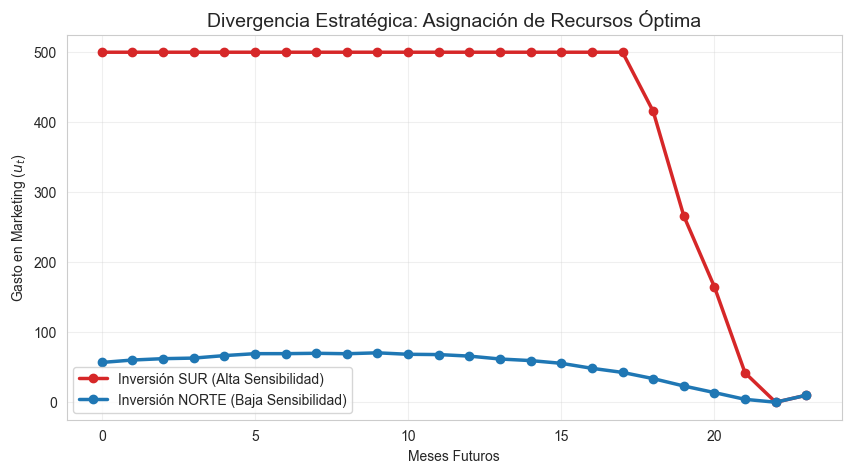


--- Stress test avanzado (AR-1) ---


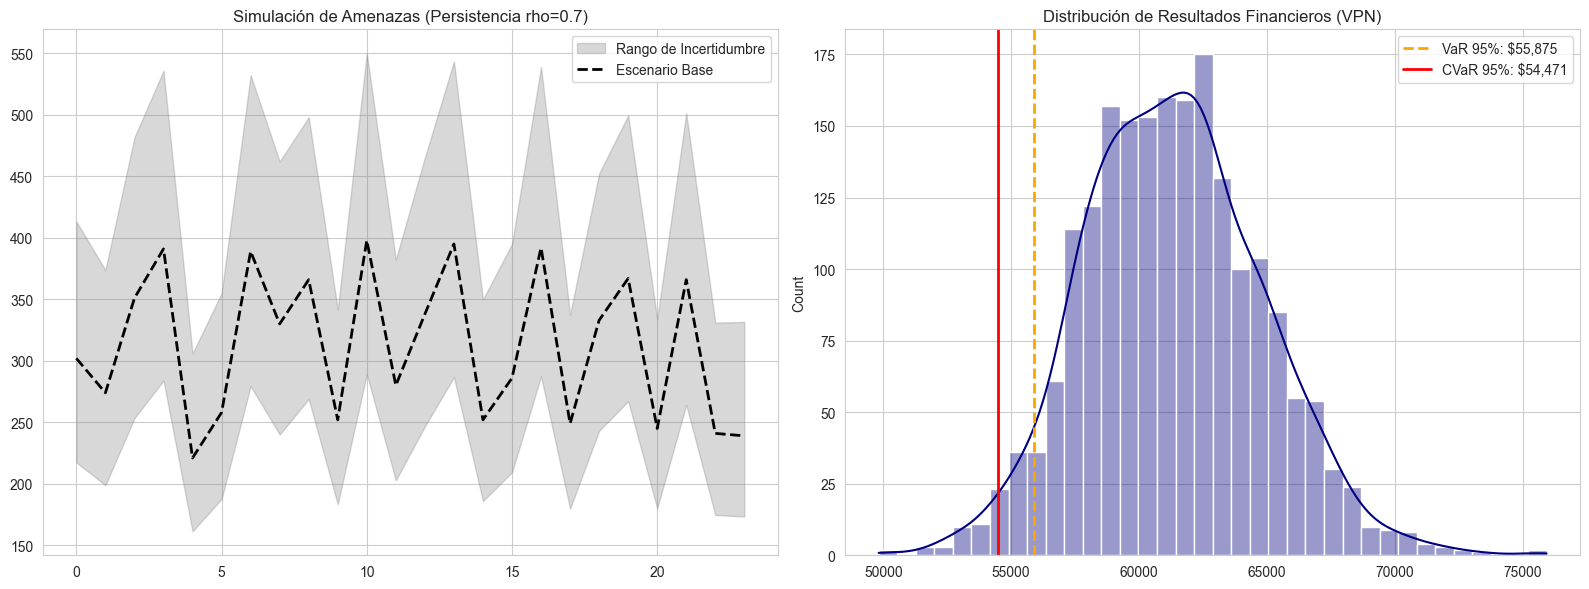

MÉTRICAS CLAVE DE RIESGO:
1. Retorno Esperado: $61,339
2. VaR 95% (Suelo):  $55,875
3. CVaR 95% (Crisis):$54,471
4. Prob. Pérdida:    0.00%


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

# Escenario
T = 24  # Horizonte de 2 años
r = 0.05
delta = 0.15
gamma = 0.4
precio = 3.0

# Volatilidad histórica para el riesgo
volatilidad = datos_simulacion['ln_Inseg'].std()
inseguridad_base = np.exp(datos_simulacion['ln_Inseg'].values[:T])

# Perfiles de regiones
perfiles_regionales = {
    'SUR (Alta Sensibilidad)': {'beta': beta_sur_est, 'color': 'tab:red'},
    'NORTE (Baja Sensibilidad)': {'beta': beta_norte_est, 'color': 'tab:blue'}
}

# Comparativa de la optimizacion por region
print("--- Politicas Optimas por region ---")
resultados_optimos = {}

def objetivo_negocio(u_path, beta_region):
    G = np.zeros(T)
    G[0] = 100
    ventas = np.zeros(T)
    vpn = 0
    for t in range(T - 1):
        G[t+1] = (1 - delta) * G[t] + np.sqrt(u_path[t] + 1e-6)
        ventas[t] = 10 * (inseguridad_base[t] ** beta_region) * (G[t] ** gamma)
        flujo = (precio * ventas[t]) - u_path[t]
        vpn += flujo * np.exp(-r * t)
    return -vpn

for nombre, perfil in perfiles_regionales.items():
    res = minimize(objetivo_negocio, np.ones(T) * 10, args=(perfil['beta']),
                   method='L-BFGS-B', bounds=[(0, 500) for _ in range(T)])
    resultados_optimos[nombre] = {'u_optimo': res.x, 'color': perfil['color']}

# Gráfico A: Comparativa Estratégica
plt.figure(figsize=(10, 5))
for nombre, data in resultados_optimos.items():
    plt.plot(data['u_optimo'], label=f"Inversión {nombre}", color=data['color'], linewidth=2.5, marker='o')
plt.title('Divergencia Estratégica: Asignación de Recursos Óptima', fontsize=14)
plt.ylabel('Gasto en Marketing ($u_t$)')
plt.xlabel('Meses Futuros')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Estrategia para el Sur
print("\n--- Stress test avanzado (AR-1) ---")
# Seleccionamos la estrategia más arriesgada (Sur) para probar su robustez
u_test = resultados_optimos['SUR (Alta Sensibilidad)']['u_optimo']
beta_test = perfiles_regionales['SUR (Alta Sensibilidad)']['beta']

n_simulaciones = 2000
rho = 0.7 # Persistencia del miedo
vpns_simulados = []
trayectorias_inseguridad = np.zeros((n_simulaciones, T))

np.random.seed(42)

for k in range(n_simulaciones):
    # Generación de Shocks con Memoria (AR-1)
    shocks = np.zeros(T)
    shocks[0] = np.random.normal(0, volatilidad)
    for t in range(1, T):
        ruido = np.random.normal(0, volatilidad * np.sqrt(1 - rho**2))
        shocks[t] = rho * shocks[t-1] + ruido
    
    inseguridad_sim = inseguridad_base * np.exp(shocks)
    trayectorias_inseguridad[k, :] = inseguridad_sim
    
    # Evaluar VPN en este escenario
    G_sim = np.zeros(T); G_sim[0] = 100
    vpn_k = 0
    for t in range(T - 1):
        G_sim[t+1] = (1 - delta) * G_sim[t] + np.sqrt(u_test[t] + 1e-6)
        ventas_t = 10 * (inseguridad_sim[t] ** beta_test) * (G_sim[t] ** gamma)
        flujo = (precio * ventas_t) - u_test[t]
        vpn_k += flujo * np.exp(-r * t)
    vpns_simulados.append(vpn_k)

vpns_array = np.array(vpns_simulados)

# Visualizacion
var_95 = np.percentile(vpns_array, 5)
cvar_95 = vpns_array[vpns_array <= var_95].mean()
prob_perdida = (vpns_array < 0).mean() * 100

# Perfil de Riesgo
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel Izquierdo: Escenarios de Inseguridad
p05 = np.percentile(trayectorias_inseguridad, 5, axis=0)
p95 = np.percentile(trayectorias_inseguridad, 95, axis=0)
axes[0].fill_between(range(T), p05, p95, color='gray', alpha=0.3, label='Rango de Incertidumbre')
axes[0].plot(inseguridad_base, 'k--', linewidth=2, label='Escenario Base')
axes[0].set_title(f'Simulación de Amenazas (Persistencia rho={rho})')
axes[0].legend()

# Panel Derecho: Distribución de Resultados
sns.histplot(vpns_array, kde=True, color='navy', ax=axes[1], alpha=0.4)
axes[1].axvline(var_95, color='orange', linestyle='--', linewidth=2, label=f'VaR 95%: ${var_95:,.0f}')
axes[1].axvline(cvar_95, color='red', linestyle='-', linewidth=2, label=f'CVaR 95%: ${cvar_95:,.0f}')
axes[1].set_title('Distribución de Resultados Financieros (VPN)')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"MÉTRICAS CLAVE DE RIESGO:")
print(f"1. Retorno Esperado: ${vpns_array.mean():,.0f}")
print(f"2. VaR 95% (Suelo):  ${var_95:,.0f}")
print(f"3. CVaR 95% (Crisis):${cvar_95:,.0f}")
print(f"4. Prob. Pérdida:    {prob_perdida:.2f}%")

In [5]:
from statsmodels.tsa.ar_model import AutoReg

u_sur = u_test 
beta_sur = beta_test
vpn_promedio = vpns_array.mean()
sharpe_ratio = vpns_array.mean() / vpns_array.std()

print("\n--- Validacion de supuestos ---")

try:
    modelo_validacion = AutoReg(datos_simulacion['ln_Inseg'], lags=1).fit()
    rho_estimado = modelo_validacion.params.iloc[1]

    print(f"Persistencia (Rho) asumida en Monte Carlo: {rho:.2f}")
    print(f"Persistencia (Rho) real en datos históricos: {rho_estimado:.2f}")

    if abs(rho - rho_estimado) < 0.2:
        print("El supuesto de persistencia es razonable y consistente con la historia.")
    else:
        print("Nota: El escenario de estrés asume una persistencia distinta a la histórica (Stress Test Severo).")
except Exception as e:
    print(f"Nota: No se pudo completar el backtesting automático ({e}). Se asume Rho={rho} como parámetro de estrés.")

print("\n--- Control ejecutivo ---")

# DataFrame 
metrics_df = pd.DataFrame({
    'Métrica Financiera': ['VPN Esperado (Base)', 'Retorno Promedio (Simulado)', 'VaR 95% (Suelo)', 'CVaR 95% (Crisis)', 'Ratio de Sharpe'],
    'Valor ($)': [
        f"${-objetivo_negocio(u_sur, beta_sur):,.0f}", 
        f"${vpn_promedio:,.0f}",
        f"${var_95:,.0f}",
        f"${cvar_95:,.0f}",
        f"{sharpe_ratio:.2f} x"
    ],
    'Interpretación de Negocio': [
        'Beneficio proyectado si el futuro es igual al pasado.',
        'Beneficio medio considerando 2,000 escenarios posibles.',
        'En el 95% de los casos, ganaremos al menos esto.',
        'Si ocurre un desastre (Top 5% peor), este es el promedio de pérdida.',
        'Eficiencia: Retorno obtenido por cada unidad de riesgo asumida.'
    ]
})

display(metrics_df)

# Recomendación
recomendacion = "Mantener estrategia" if sharpe_ratio > 1.0 and prob_perdida < 5 else "Revisar estrategia (Riesgo Alto)"

print(f"\n📢 Conclusion: {recomendacion}")
print(f"Justificación: El Ratio de Sharpe es {sharpe_ratio:.2f} y la probabilidad de pérdida es solo del {prob_perdida:.2f}%.")


--- Validacion de supuestos ---
Persistencia (Rho) asumida en Monte Carlo: 0.70
Persistencia (Rho) real en datos históricos: -0.33
Nota: El escenario de estrés asume una persistencia distinta a la histórica (Stress Test Severo).

--- Control ejecutivo ---


,Métrica Financiera,Valor ($),Interpretación de Negocio
0,VPN Esperado (Base),"$60,990",Beneficio proyectado si el futuro es igual al ...
1,Retorno Promedio (Simulado),"$61,339","Beneficio medio considerando 2,000 escenarios ..."
2,VaR 95% (Suelo),"$55,875","En el 95% de los casos, ganaremos al menos esto."
3,CVaR 95% (Crisis),"$54,471","Si ocurre un desastre (Top 5% peor), este es e..."
4,Ratio de Sharpe,17.68 x,Eficiencia: Retorno obtenido por cada unidad d...



📢 Conclusion: Mantener estrategia
Justificación: El Ratio de Sharpe es 17.68 y la probabilidad de pérdida es solo del 0.00%.


/var/folders/7d/9m1z02w57lz0wv747gg7kt6w0000gn/T/ipykernel_83313/507408992.py:126: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/7d/9m1z02w57lz0wv747gg7kt6w0000gn/T/ipykernel_83313/507408992.py:126: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/7d/9m1z02w57lz0wv747gg7kt6w0000gn/T/ipykernel_83313/507408992.py:126: UserWarning: Glyph 128737 (\N{SHIELD}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/7d/9m1z02w57lz0wv747gg7kt6w0000gn/T/ipykernel_83313/507408992.py:126: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/Users/abraham/Library/CloudStorage/OneDrive-Personal/Proyecto cv/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_fig

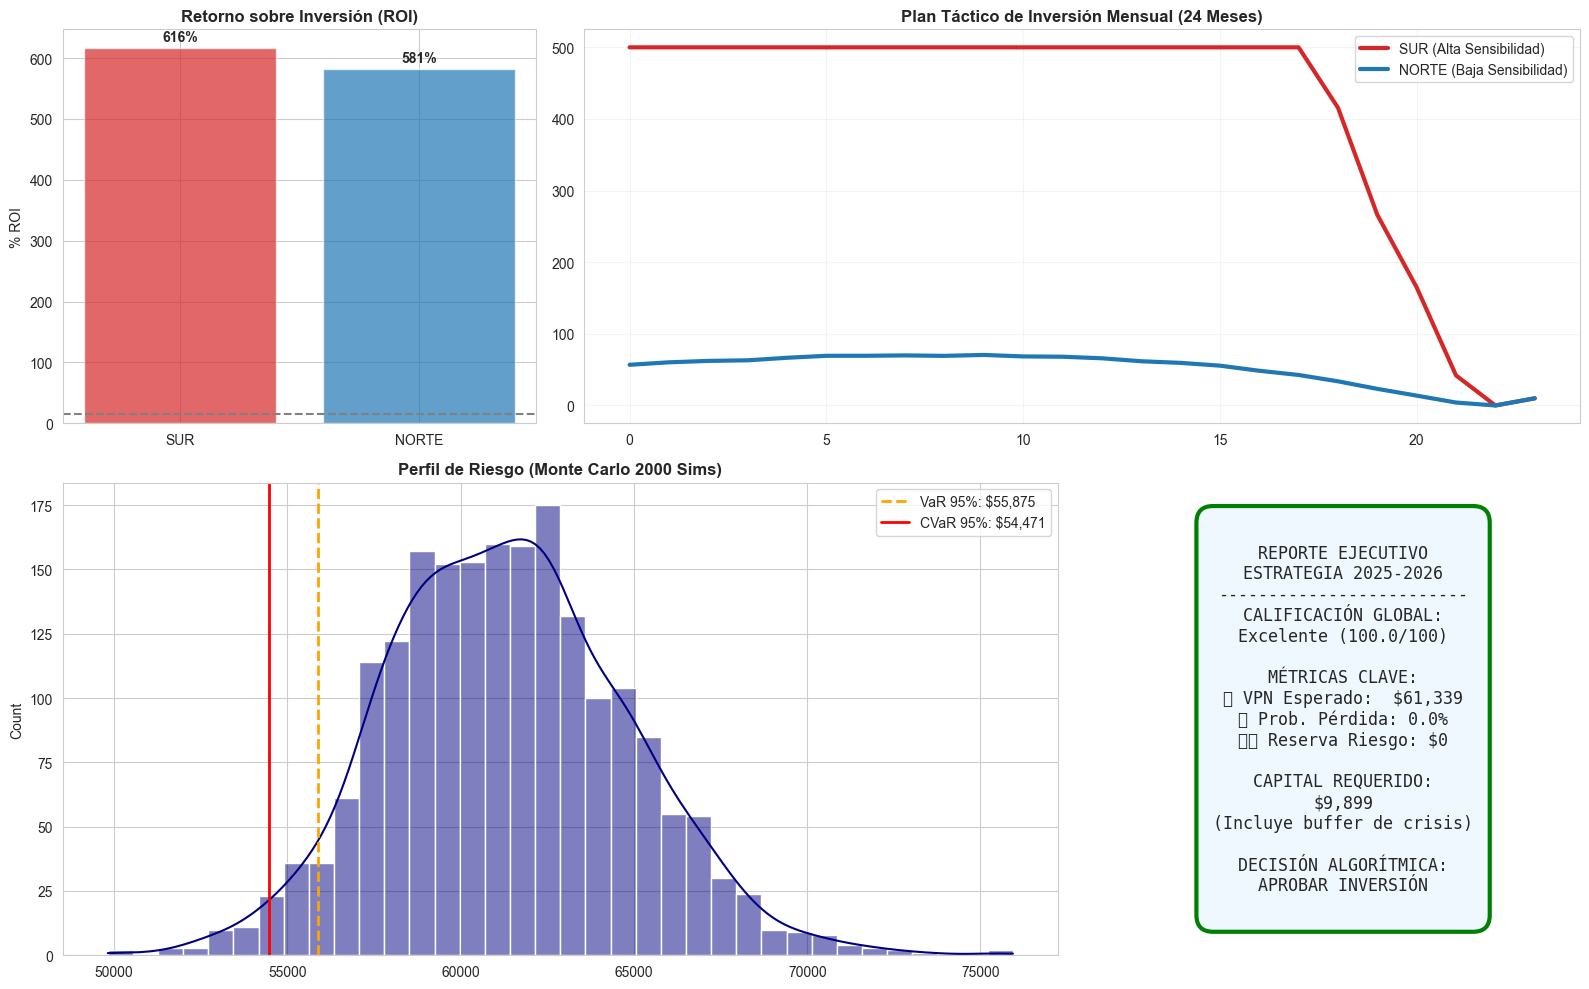

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import matplotlib.gridspec as gridspec

# Oprimizacion y Stress Test
T = 24; r = 0.05; delta = 0.15; gamma = 0.4; precio = 3.0
volatilidad = datos_simulacion['ln_Inseg'].std()
inseguridad_base = np.exp(datos_simulacion['ln_Inseg'].values[:T])
perfiles_regionales = {
    'SUR (Alta Sensibilidad)': {'beta': beta_sur_est, 'color': 'tab:red'},
    'NORTE (Baja Sensibilidad)': {'beta': beta_norte_est, 'color': 'tab:blue'}
}

# Optimización Regional
resultados_optimos = {}
def objetivo_negocio(u_path, beta_region):
    G = np.zeros(T); G[0] = 100
    ventas = np.zeros(T); vpn = 0
    for t in range(T - 1):
        G[t+1] = (1 - delta) * G[t] + np.sqrt(u_path[t] + 1e-6)
        ventas[t] = 10 * (inseguridad_base[t] ** beta_region) * (G[t] ** gamma)
        flujo = (precio * ventas[t]) - u_path[t]
        vpn += flujo * np.exp(-r * t)
    return -vpn

for nombre, perfil in perfiles_regionales.items():
    res = minimize(objetivo_negocio, np.ones(T)*10, args=(perfil['beta']), method='L-BFGS-B', bounds=[(0, 500) for _ in range(T)])
    resultados_optimos[nombre] = {'u_optimo': res.x, 'color': perfil['color'], 'roi': (-res.fun/res.x.sum())*100}

# Stress Test (Monte Carlo AR-1)
u_test = resultados_optimos['SUR (Alta Sensibilidad)']['u_optimo']
n_sim = 2000; rho = 0.7; vpns_simulados = []
np.random.seed(42)
for k in range(n_sim):
    shocks = np.zeros(T); shocks[0] = np.random.normal(0, volatilidad)
    for t in range(1, T): shocks[t] = rho*shocks[t-1] + np.random.normal(0, volatilidad*np.sqrt(1-rho**2))
    inseg_sim = inseguridad_base * np.exp(shocks)
    
    G=np.zeros(T); G[0]=100; vpn_k=0
    for t in range(T-1):
        G[t+1] = (1-delta)*G[t] + np.sqrt(u_test[t]+1e-6)
        vt = 10 * (inseg_sim[t] ** beta_sur_est) * (G[t] ** gamma)
        vpn_k += ((precio*vt) - u_test[t]) * np.exp(-r*t)
    vpns_simulados.append(vpn_k)

vpns_array = np.array(vpns_simulados)
var_95 = np.percentile(vpns_array, 5)
cvar_95 = vpns_array[vpns_array <= var_95].mean()
prob_perdida = (vpns_array < 0).mean() * 100

# --- Calculo de score de riesgo y reserva ---
reserva_riesgo = abs(min(0, cvar_95)) * 1.5 # Buffer del 150% de la pérdida extrema
capital_total = u_test.sum() + reserva_riesgo

# Score compuesto 
score_retorno = min(100, vpns_array.mean() / 50000 * 40) # 40% peso
score_cola = 100 - (abs(min(0, cvar_95)) / 10000 * 30)   # 30% peso
score_prob = 100 - (prob_perdida * 3)                    # 30% peso
score_total = max(0, min(100, score_retorno + score_cola + score_prob))

if score_total >= 80: rating = "Excelente"; color_rating = "green"
elif score_total >= 60: rating = "Bueno"; color_rating = "orange"
else: rating = "Riesgoso"; color_rating = "red"

# --- Dashboard ---
fig = plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1.2])

# A. ROI comparativo 
ax1 = plt.subplot(gs[0, 0])
nombres = [n.split(' ')[0] for n in resultados_optimos.keys()]
rois = [d['roi'] for d in resultados_optimos.values()]
colors = [d['color'] for d in resultados_optimos.values()]
bars = ax1.bar(nombres, rois, color=colors, alpha=0.7)
ax1.axhline(15, color='gray', linestyle='--', label='Hurdle Rate (15%)')
ax1.bar_label(bars, fmt='%.0f%%', padding=3, fontweight='bold')
ax1.set_title('Retorno sobre Inversión (ROI)', fontweight='bold')
ax1.set_ylabel('% ROI')

# B. Estrategias de inversión 
ax2 = plt.subplot(gs[0, 1:])
for nombre, data in resultados_optimos.items():
    ax2.plot(data['u_optimo'], label=nombre, color=data['color'], linewidth=3)
ax2.set_title('Plan Táctico de Inversión Mensual (24 Meses)', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.2)

# C. Distribución de eiesgo 
ax3 = plt.subplot(gs[1, :2])
sns.histplot(vpns_array, kde=True, color='navy', ax=ax3, alpha=0.5)
ax3.axvline(var_95, color='orange', linestyle='--', linewidth=2, label=f'VaR 95%: ${var_95:,.0f}')
ax3.axvline(cvar_95, color='red', linestyle='-', linewidth=2, label=f'CVaR 95%: ${cvar_95:,.0f}')
ax3.set_title(f'Perfil de Riesgo (Monte Carlo {n_sim} Sims)', fontweight='bold')
ax3.legend()

# D. Scorecard 
ax4 = plt.subplot(gs[1, 2])
ax4.axis('off')

texto_scorecard = f"""
REPORTE EJECUTIVO
ESTRATEGIA 2025-2026
-------------------------
CALIFICACIÓN GLOBAL:
{rating} ({score_total:.1f}/100)

MÉTRICAS CLAVE:
VPN Esperado:  ${vpns_array.mean():,.0f}
Prob. Pérdida: {prob_perdida:.1f}%
Reserva Riesgo: ${reserva_riesgo:,.0f}

CAPITAL REQUERIDO:
${capital_total:,.0f}
(Incluye buffer de crisis)

DECISIÓN ALGORÍTMICA:
{"APROBAR INVERSIÓN" if score_total > 60 else "DENEGAR / REVISAR"}
"""

ax4.text(0.5, 0.5, texto_scorecard, ha='center', va='center', fontsize=12, family='monospace',
         bbox=dict(boxstyle="round,pad=1", facecolor="aliceblue", edgecolor=color_rating, linewidth=3))

plt.tight_layout()
plt.show()